In [1]:
!pip install eli5==0.13.0

# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
from shapely.geometry import Point
import geopandas as gpd
from geopandas.tools import sjoin
import pyproj
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import optuna
from sklearn.model_selection import train_test_split, KFold
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

from sklearn.inspection import permutation_importance
from matplotlib import rc

In [2]:
bus_path = 'data/bus_feature.csv'
subway_path  = 'data/subway_feature.csv'
dt_bus = pd.read_csv(bus_path)
dt_subway = pd.read_csv(subway_path)

In [3]:
train_path = 'data/train.csv'
test_path  = 'data/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

In [4]:
xy_path  = 'data/xy좌표.csv'
dt_xy = pd.read_csv(xy_path, encoding='cp949')

In [5]:
#train + test
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test]) 
concat['is_test'].value_counts()

is_test
0    1118822
1       9272
Name: count, dtype: int64

In [6]:
# 시군구와 번지를 기준으로 concat과 dt_xy를 병합
merged_df = pd.merge(concat, dt_xy[['시군구', '번지', 'x', 'y']], how='left', on=['시군구', '번지'])

# 결측치 처리 함수
def handle_missing_values(df):
    # 좌표 X, Y 결측치 처리
    # 좌표 결측치는 평균값으로 대체하는 예시
    imputer = SimpleImputer(strategy='mean')
    df[['좌표X', '좌표Y']] = imputer.fit_transform(df[['좌표X', '좌표Y']])
    
    return df
    
concat = handle_missing_values(concat)

remaining_missing = concat[['좌표X', '좌표Y']].isnull().sum()
print(remaining_missing)

좌표X    0
좌표Y    0
dtype: int64


In [7]:
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

In [8]:
# 각 변수별 결측치 개수와 비율 계산
missing_values = concat.isnull().sum()
missing_percentage = (missing_values / len(concat)) * 100

missing_data = pd.DataFrame({
    '변수명': concat.columns,
    '결측치 개수': missing_values,
    '결측치 비율 (%)': missing_percentage
})

# 결측치 비율 내림차순
missing_data = missing_data.sort_values(by='결측치 비율 (%)', ascending=False).reset_index(drop=True)

print(missing_data)

                       변수명   결측치 개수  결측치 비율 (%)
0                 k-135㎡초과  1127765   99.970836
1                  해제사유발생일  1121899   99.450844
2                   k-등록일자  1116386   98.962143
3               단지소개기존clob  1058958   93.871433
4                   k-홈페이지  1013523   89.843843
5                 고용보험관리번호   920757   81.620592
6                 세대전기계약방법   885389   78.485392
7                   k-팩스번호   879348   77.949887
8                    k-시행사   877834   77.815678
9                  청소비관리형태   877751   77.808321
10              k-건설사(시공사)   877637   77.798215
11                 경비비관리형태   877561   77.791478
12      k-단지분류(아파트,주상복합등등)   877273   77.765949
13                  k-전체동수   877207   77.760098
14                   단지승인일   876854   77.728806
15                  k-전화번호   876850   77.728452
16                  k-복도유형   876454   77.693348
17                    건축면적   876279   77.677835
18                    주차대수   876277   77.677658
19           k-사용검사일-사용승인일   876259   77

In [9]:
# 'k-'로 시작하는 열
k_columns = [col for col in concat.columns if col.startswith('k-')]

# '결측치 비율 출력
missing_k_data = missing_data[missing_data['변수명'].isin(k_columns)]
print(missing_k_data)

# 'k-'로 시작하는 열 제거
concat = concat.drop(columns=k_columns)

print(f"제거된 변수: {k_columns}")
print(f"남은 변수 개수: {concat.shape[1]}")
print(concat.head())

                       변수명   결측치 개수  결측치 비율 (%)
0                 k-135㎡초과  1127765   99.970836
2                   k-등록일자  1116386   98.962143
4                   k-홈페이지  1013523   89.843843
7                   k-팩스번호   879348   77.949887
8                    k-시행사   877834   77.815678
10              k-건설사(시공사)   877637   77.798215
12      k-단지분류(아파트,주상복합등등)   877273   77.765949
13                  k-전체동수   877207   77.760098
15                  k-전화번호   876850   77.728452
16                  k-복도유형   876454   77.693348
19           k-사용검사일-사용승인일   876259   77.676062
21  k-전용면적별세대현황(60㎡~85㎡이하)   876170   77.668173
22      k-전용면적별세대현황(60㎡이하)   876170   77.668173
23                  k-수정일자   876170   77.668173
24                k-주거전용면적   876170   77.668173
25            k-85㎡~135㎡이하   876170   77.668173
26                   k-연면적   876125   77.664184
27               k-관리비부과면적   876125   77.664184
30                 k-전체세대수   876125   77.664184
31                  k-난방방식   876125   77

In [10]:
# 필요없는 열 삭제
columns_to_remove = ['등기신청일자', '거래유형', '중개사소재지', 
                    '고용보험관리번호', '경비비관리형태', '세대전기계약방법', 
                     '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', 
                     '관리비 업로드', '단지신청일', '사용허가여부', '건축면적', '해제사유발생일', '단지소개기존clob']

concat= concat.drop(columns=columns_to_remove)

In [11]:
concat.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도',
       '도로명', '주차대수', '좌표X', '좌표Y', 'target', 'is_test'],
      dtype='object')

In [12]:
# 1. '시군구'에서 '서울특별시'를 제거하고 '구'와 '동'으로 나누기
concat['구'] = concat['시군구'].str.split(' ').str[1]  # '구' 부분 추출
concat['동'] = concat['시군구'].str.split(' ').str[2]  # '동' 부분 추출

# 2. '계약년월'에서 연도 추출 후 건축년도와의 차이를 계산하여 '구매당시 아파트 나이' 열 추가
concat['계약연도'] = concat['계약년월'].astype(str).str[:4].astype(int)  # 계약년월에서 연도만 추출
concat['아파트Age'] = concat['계약연도'] - concat['건축년도']  # 건축년도와의 차이 계산

concat.drop(columns=['시군구', '계약일', '건축년도'], inplace=True)

# 결과 확인
concat.head(10)

,번지,본번,부번,아파트명,전용면적,계약년월,층,도로명,주차대수,좌표X,좌표Y,target,is_test,구,동,계약연도,아파트Age
0,658-1,658.0,1.0,개포6차우성,79.97,201712,3,언주로 3,262.0,127.05721,37.476763,124000.0,0,강남구,개포동,2017,30
1,658-1,658.0,1.0,개포6차우성,79.97,201712,4,언주로 3,262.0,127.05721,37.476763,123500.0,0,강남구,개포동,2017,30
2,658-1,658.0,1.0,개포6차우성,54.98,201712,5,언주로 3,262.0,127.05721,37.476763,91500.0,0,강남구,개포동,2017,30
3,658-1,658.0,1.0,개포6차우성,79.97,201801,4,언주로 3,262.0,127.05721,37.476763,130000.0,0,강남구,개포동,2018,31
4,658-1,658.0,1.0,개포6차우성,79.97,201801,2,언주로 3,262.0,127.05721,37.476763,117000.0,0,강남구,개포동,2018,31
5,658-1,658.0,1.0,개포6차우성,79.97,201801,1,언주로 3,262.0,127.05721,37.476763,130000.0,0,강남구,개포동,2018,31
6,658-1,658.0,1.0,개포6차우성,79.97,201803,2,언주로 3,262.0,127.05721,37.476763,139500.0,0,강남구,개포동,2018,31
7,658-1,658.0,1.0,개포6차우성,54.98,201804,5,언주로 3,262.0,127.05721,37.476763,107500.0,0,강남구,개포동,2018,31
8,658-1,658.0,1.0,개포6차우성,79.97,201806,3,언주로 3,262.0,127.05721,37.476763,145000.0,0,강남구,개포동,2018,31
9,658-1,658.0,1.0,개포6차우성,54.98,201807,3,언주로 3,262.0,127.05721,37.476763,112000.0,0,강남구,개포동,2018,31


In [13]:
#30년 over 됐는지 
concat['30년 건축'] = concat['아파트Age'].apply(lambda x : 1 if x >= 30 else 0)

In [14]:
#x,y 좌표 -> 버스 정류장, 지하철역

def preprocess_data(df, x_col, y_col):
    wgs84 = pyproj.CRS('EPSG:4326')  # WGS84 좌표계 (위도, 경도)
    utm_k = pyproj.CRS('EPSG:5179')  # UTM-K 좌표계 (한국)
    project = pyproj.Transformer.from_crs(wgs84, utm_k, always_xy=True).transform
    
    df['geometry'] = df.apply(lambda row: Point(project(row[x_col], row[y_col])), axis=1)
    return gpd.GeoDataFrame(df, geometry='geometry', crs=utm_k)

def calculate_density(gdf_real_estate, gdf_locations, radius):
    gdf_real_estate['buffer'] = gdf_real_estate.geometry.buffer(radius)
    
    joined = sjoin(gdf_locations, gdf_real_estate.set_geometry('buffer'), how='inner', predicate='within')
    
    density = joined.groupby(joined.index_right).size().rename('density')
    
    return gdf_real_estate.join(density, how='left').fillna(0)['density']

def process_in_chunks(df, locations_gdf, radius, chunk_size=10000):
    results = []
    for i in tqdm(range(0, len(df), chunk_size)):
        chunk = df.iloc[i:i+chunk_size]
        chunk_gdf = preprocess_data(chunk, '좌표X', '좌표Y')
        density = calculate_density(chunk_gdf, locations_gdf, radius)
        results.append(density)
    return pd.concat(results)

# 버스 정류장과 지하철역 데이터 전처리
bus_gdf = preprocess_data(dt_bus, 'X좌표', 'Y좌표')  # 버스 정류장 좌표계 변환

# 지하철 데이터는 위도, 경도 데이터를 X, Y로 변환
subway_gdf = preprocess_data(dt_subway, '경도', '위도')  # 지하철 데이터도 동일하게 좌표 변환

# 반경 설정
bus_radius = 500  # 미터 단위
subway_radius = 1000  # 1km를 미터 단위로 표현

# 청크 크기 설정
chunk_size = 10000

print("버스 정류장 밀도 계산 중 (500m 반경)...")
concat['bus_stop_density_500m'] = process_in_chunks(concat, bus_gdf, bus_radius, chunk_size)

print("지하철역 밀도 계산 중 (1km 반경)...")
concat['subway_station_density_1km'] = process_in_chunks(concat, subway_gdf, subway_radius, chunk_size)

# 결과 출력
print(concat[['좌표X', '좌표Y', 'bus_stop_density_500m', 'subway_station_density_1km']].head())

버스 정류장 밀도 계산 중 (500m 반경)...


100%|█████████████████████████████████████████| 113/113 [00:17<00:00,  6.55it/s]


지하철역 밀도 계산 중 (1km 반경)...


100%|█████████████████████████████████████████| 113/113 [00:15<00:00,  7.48it/s]

         좌표X        좌표Y  bus_stop_density_500m  subway_station_density_1km
0  127.05721  37.476763                     13                         0.0
1  127.05721  37.476763                     13                         0.0
2  127.05721  37.476763                     13                         0.0
3  127.05721  37.476763                     13                         0.0
4  127.05721  37.476763                     13                         0.0


In [15]:
# '구'의 평균 가격을 기준
gu_order = concat.groupby('구')['target'].mean().sort_values(ascending=False).index.tolist()
gu_mapping = {gu: label for label, gu in enumerate(gu_order)}

# '구'를 평균 가격 순위에 따라 인코딩
concat['new_구'] = concat['구'].map(gu_mapping)

In [16]:
# '동'의 평균 가격을 기준으로 순위를 매김
dong_order = concat.groupby('동')['target'].mean().sort_values(ascending=False).index.tolist()
dong_mapping = {dong: label for label, dong in enumerate(dong_order)}

# '동'을 평균 가격 순위에 따라 인코딩
concat['new_동'] = concat['동'].map(dong_mapping)

In [17]:
# '동'별 target의 표준편차 계산
dong_std_order = concat.groupby('동')['target'].std().sort_values(ascending=False).index.tolist()

# 표준편차를 기준으로 '동'을 순위 매김
dong_std_mapping = {dong: label for label, dong in enumerate(dong_std_order)}

# '동'을 표준편차 순위에 따라 인코딩
concat['동_std'] = concat['동'].map(dong_std_mapping)
print(concat[['동', '동_std']].head())

     동  동_std
0  개포동     27
1  개포동     27
2  개포동     27
3  개포동     27
4  개포동     27


In [18]:
#아파트명 -> cluster

# 'train_test' 열이 없다면 concat이 학습 데이터
train = concat.copy()  
# 'target'의 NaN 값 처리 및 정수변환
train['target'] = train['target'].replace([np.inf, -np.inf], np.nan).fillna(0)
train['target'] = train['target'].astype('int')

#groupby, 아파트 평균 가격 배열 생성
data = train[['아파트명', 'target']].groupby('아파트명').mean()
arr = data['target'].to_numpy().reshape(-1, 1)

# cluster
k = 5  
kmeans = KMeans(n_clusters=k, n_init=10)
kmeans.fit(arr)
sort_order = np.argsort(kmeans.cluster_centers_.flatten())

# 군집화 결과를 가격 순서대로 
labels = np.zeros_like(kmeans.labels_)
# 각 클러스터를 가격 순서대로
for i, cluster in enumerate(sort_order):
    labels = np.where(kmeans.labels_ == cluster, i, labels)

# 군집화 결과와 가격을 데이터에 추가
data['cluster'] = labels
data = data.reset_index()
data = data[['아파트명', 'cluster']]

# 원본 데이터프레임에 클러스터 정보 추가 (아파트명 기준 매핑)
concat['아파트명기준_cluster'] = concat['아파트명'].map(data.set_index('아파트명')['cluster'])

print(concat[['아파트명', '아파트명기준_cluster']].head())

     아파트명  아파트명기준_cluster
0  개포6차우성             1.0
1  개포6차우성             1.0
2  개포6차우성             1.0
3  개포6차우성             1.0
4  개포6차우성             1.0


In [19]:
#강남역기준 영향
def calculate_distance(lat1, lon1, lat2, lon2):
    # 거리 계산 함수(유클리드)
    return np.sqrt((lat1 - lat2)**2 + (lon1 - lon2)**2)

gangnam_center_lat, gangnam_center_lon = 37.4979, 127.0276  # 강남역

concat['강남_거리'] = calculate_distance(concat['좌표Y'], concat['좌표X'], gangnam_center_lat, gangnam_center_lon)

In [20]:
#2019년 이후로 전용면적에 따른 거래건수, 최근가격변동률

concat['계약년월'] = pd.to_datetime(concat['계약년월'], format='%Y%m')
concat['계약년'] = concat['계약년월'].dt.year

# 2019년 이후 데이터 필터링
recent_years = concat[concat['계약년'] >= 2019].copy()

# 전용면적 기준으로 유사한 면적 범위의 데이터 필터링 및 그룹화
recent_years['전용면적_bin'] = (recent_years['전용면적'] // 5) * 5  # 전용면적을 5의 범위로 구분

# 그룹화된 데이터에서 파생변수 계산 (전용면적 ±5 범위를 고려)
recent_years_agg = recent_years.groupby(['new_구', '전용면적_bin']).agg(
    최근_거래건수=('target', 'size'),
    첫번째가격=('target', 'first'),
    마지막가격=('target', 'last')
).reset_index()

# 가격 변동률 계산
recent_years_agg['최근_가격변동률'] = (recent_years_agg['마지막가격'] - recent_years_agg['첫번째가격']) / recent_years_agg['첫번째가격']

# 변동률 계산 후 데이터프레임 확인
print("가격 변동률 계산 후 recent_years_agg 데이터프레임:")
print(recent_years_agg.head())  # 중간 확인용 출력

# concat에서도 동일한 범위로 전용면적을 구분
concat['전용면적_bin'] = (concat['전용면적'] // 5) * 5

# '구'와 '전용면적_bin'을 기준으로 병합을 위한 dictionary 생성
recent_years_agg_dict = recent_years_agg.set_index(['new_구', '전용면적_bin']).to_dict('index')

# 파생변수를 생성할 컬럼을 미리 준비
concat['최근_거래건수'] = concat.apply(lambda x: recent_years_agg_dict.get((x['new_구'], x['전용면적_bin']), {}).get('최근_거래건수', np.nan), axis=1)
concat['최근_가격변동률'] = concat.apply(lambda x: recent_years_agg_dict.get((x['new_구'], x['전용면적_bin']), {}).get('최근_가격변동률', np.nan), axis=1)

# '전용면적_bin' 컬럼 제거
concat = concat.drop(columns=['전용면적_bin'])

# 병합 후 결과 확인 (결측치 개수 확인)
print("after merge: 결측치 개수:")
print(concat[['최근_거래건수', '최근_가격변동률']].isnull().sum())

# 결과 확인
print(concat[['계약년', '전용면적', 'new_구', '최근_거래건수', '최근_가격변동률']].head(10))


가격 변동률 계산 후 recent_years_agg 데이터프레임:
   new_구  전용면적_bin  최근_거래건수    첫번째가격    마지막가격  최근_가격변동률
0      0      10.0       69  14000.0  24000.0  0.714286
1      0      15.0      104  21700.0  32400.0  0.493088
2      0      20.0       62  28000.0  36500.0  0.303571
3      0      25.0      159  34500.0  28000.0 -0.188406
4      0      30.0      644  39800.0  33000.0 -0.170854
after merge: 결측치 개수:
최근_거래건수     219
최근_가격변동률    222
dtype: int64
    계약년   전용면적  new_구  최근_거래건수  최근_가격변동률
0  2017  79.97      0    479.0  0.075377
1  2017  79.97      0    479.0  0.075377
2  2017  54.98      0    263.0 -0.523333
3  2018  79.97      0    479.0  0.075377
4  2018  79.97      0    479.0  0.075377
5  2018  79.97      0    479.0  0.075377
6  2018  79.97      0    479.0  0.075377
7  2018  54.98      0    263.0 -0.523333
8  2018  79.97      0    479.0  0.075377
9  2018  54.98      0    263.0 -0.523333


In [21]:
# 최근_거래건수의 결측치를 0으로 채움
concat['최근_거래건수'].fillna(0, inplace=True)

# 최근_가격변동률의 결측치를 0으로 채움
concat['최근_가격변동률'].fillna(0, inplace=True)

# 결측치 대체 후 결과 확인
print("결측치 대체 후 데이터프레임 확인:")
print(concat[['계약년', '전용면적', '구', '최근_거래건수', '최근_가격변동률']].head(10))

print("결측치 개수 확인:")
print(concat[['최근_거래건수', '최근_가격변동률']].isnull().sum())

결측치 대체 후 데이터프레임 확인:
    계약년   전용면적    구  최근_거래건수  최근_가격변동률
0  2017  79.97  강남구    479.0  0.075377
1  2017  79.97  강남구    479.0  0.075377
2  2017  54.98  강남구    263.0 -0.523333
3  2018  79.97  강남구    479.0  0.075377
4  2018  79.97  강남구    479.0  0.075377
5  2018  79.97  강남구    479.0  0.075377
6  2018  79.97  강남구    479.0  0.075377
7  2018  54.98  강남구    263.0 -0.523333
8  2018  79.97  강남구    479.0  0.075377
9  2018  54.98  강남구    263.0 -0.523333
결측치 개수 확인:
최근_거래건수     0
최근_가격변동률    0
dtype: int64


In [ ]:
"""
concat['동_도로명 조합'] = concat['new_동'].astype(str) + '_' + concat['도로명'].astype(str)
concat['동_계약년 조합'] = concat['new_동'].astype(str) + '_' + concat['계약년월'].astype(str)
"""

In [22]:
concat = concat.drop(columns=['좌표X', '좌표Y'])

In [23]:
concat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1128094 entries, 0 to 9271
Data columns (total 26 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   번지                          1127867 non-null  object        
 1   본번                          1128019 non-null  float64       
 2   부번                          1128019 non-null  float64       
 3   아파트명                        1125958 non-null  object        
 4   전용면적                        1128094 non-null  float64       
 5   계약년월                        1128094 non-null  datetime64[ns]
 6   층                           1128094 non-null  int64         
 7   도로명                         1128094 non-null  object        
 8   주차대수                        251817 non-null   float64       
 9   target                      1118822 non-null  float64       
 10  is_test                     1128094 non-null  int64         
 11  구                           1128

In [24]:
continuous_columns = []
categorical_columns = []

for column in concat.columns:
    if pd.api.types.is_numeric_dtype(concat[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['본번', '부번', '전용면적', '층', '주차대수', 'target', 'is_test', '계약연도', '아파트Age', '30년 건축', 'bus_stop_density_500m', 'subway_station_density_1km', 'new_구', 'new_동', '동_std', '아파트명기준_cluster', '강남_거리', '계약년', '최근_거래건수', '최근_가격변동률']
범주형 변수: ['번지', '아파트명', '계약년월', '도로명', '구', '동']


In [25]:
#categorical - null
concat[categorical_columns] = concat[categorical_columns].fillna('NULL')

#continuous - linear
concat[continuous_columns] = concat[continuous_columns].interpolate(method='linear', axis=0)

In [26]:
concat.isnull().sum() 

번지                            0
본번                            0
부번                            0
아파트명                          0
전용면적                          0
계약년월                          0
층                             0
도로명                           0
주차대수                          0
target                        0
is_test                       0
구                             0
동                             0
계약연도                          0
아파트Age                        0
30년 건축                        0
bus_stop_density_500m         0
subway_station_density_1km    0
new_구                         0
new_동                         0
동_std                         0
아파트명기준_cluster                0
강남_거리                         0
계약년                           0
최근_거래건수                       0
최근_가격변동률                      0
dtype: int64

In [ ]:
average_price_by_gu = concat_select.groupby('구')['target'].mean().reset_index()

average_price_by_gu.columns = ['구', '평균 실거래가']

# 결과 출력
print(average_price_by_gu)

plt.figure(figsize=(12, 8))
sns.barplot(data=average_price_by_gu, x='평균 실거래가', y='구', palette='viridis')
plt.title('구별 평균 실거래가')
plt.xlabel('평균 실거래가')
plt.ylabel('구')
plt.show()

In [27]:
#major Gu
all = list(concat['구'].unique())
majorGu = ['용산구','서초구', '강남구', '송파구', '성동구']
notMajorGu = [x for x in all if x not in majorGu]

assert len(all) == len(majorGu) + len(notMajorGu)

In [28]:
is_majorGu = [] 

for x in concat['구'].tolist():
    if x in majorGu:
        is_majorGu.append(1)
    else:
        is_majorGu.append(0)

concat['비싼 구'] = is_majorGu

print(concat[['구', '비싼 구']].head())


     구  비싼 구
0  강남구     1
1  강남구     1
2  강남구     1
3  강남구     1
4  강남구     1


In [29]:
# train과 test dataset을 분할
dt_train = concat.query('is_test==0')
dt_test = concat.query('is_test==1')

# is_test drop
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1118822, 26) (9272, 26)


In [30]:
dt_test.head(5)

,번지,본번,부번,아파트명,전용면적,계약년월,층,도로명,주차대수,target,...,subway_station_density_1km,new_구,new_동,동_std,아파트명기준_cluster,강남_거리,계약년,최근_거래건수,최근_가격변동률,비싼 구
0,658-1,658.0,1.0,개포6차우성,79.9700,2023-07-01,5,언주로 3,262.0,13250.0,...,0.0,0,47,27,1.0,0.036380,2023,479.0,0.075377,1
1,651-1,651.0,1.0,개포더샵트리에,108.2017,2023-08-01,10,개포로 311,305.0,13250.0,...,5.0,0,47,27,2.0,0.031596,2023,403.0,-0.125000,1
2,652,652.0,0.0,개포우성3차,161.0000,2023-07-01,15,개포로 307,419.0,13250.0,...,4.0,0,47,27,2.0,0.031657,2023,334.0,-0.060000,1
3,652,652.0,0.0,개포우성3차,133.4600,2023-08-01,14,개포로 307,419.0,13250.0,...,4.0,0,47,27,2.0,0.031657,2023,294.0,-0.512255,1
4,652,652.0,0.0,개포우성3차,104.4300,2023-08-01,6,개포로 307,419.0,13250.0,...,4.0,0,47,27,2.0,0.031657,2023,272.0,0.397802,1


In [31]:
dt_test['target'] = 0

In [32]:
#파생변수들 추가
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['본번', '부번', '전용면적', '층', '주차대수', 'target', '계약연도', '아파트Age', '30년 건축', 'bus_stop_density_500m', 'subway_station_density_1km', 'new_구', 'new_동', '동_std', '아파트명기준_cluster', '강남_거리', '계약년', '최근_거래건수', '최근_가격변동률', '비싼 구']
범주형 변수: ['번지', '아파트명', '계약년월', '도로명', '구', '동']


In [33]:
label_encoders = {}

# Implement Label Encoding
for col in tqdm(categorical_columns_v2):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit(dt_train[col].astype(str))
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl  # 나중에 후처리를 위해 레이블 인코더를 저장

    # Test 데이터에 대해 Label Encoding 적용
    # 새로운 라벨이 존재할 경우 예외 처리
    dt_test[col] = dt_test[col].astype(str)  # Ensure test data is also string
    unseen_labels = set(dt_test[col].unique()) - set(lbl.classes_)

    if unseen_labels:
        # 새로운 라벨을 인코더에 추가
        lbl.classes_ = np.append(lbl.classes_, list(unseen_labels))

    # Test 데이터 변환
    dt_test[col] = lbl.transform(dt_test[col])

# 결과 출력 확인
print(dt_train.head())
print(dt_test.head())


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.91it/s]

     번지     본번   부번  아파트명   전용면적  계약년월  층   도로명   주차대수    target  ...  \
0  4732  658.0  1.0   328  79.97   131  3  6176  262.0  124000.0  ...   
1  4732  658.0  1.0   328  79.97   131  4  6176  262.0  123500.0  ...   
2  4732  658.0  1.0   328  54.98   131  5  6176  262.0   91500.0  ...   
3  4732  658.0  1.0   328  79.97   132  4  6176  262.0  130000.0  ...   
4  4732  658.0  1.0   328  79.97   132  2  6176  262.0  117000.0  ...   

   subway_station_density_1km  new_구  new_동  동_std  아파트명기준_cluster    강남_거리  \
0                         0.0      0     47     27             1.0  0.03638   
1                         0.0      0     47     27             1.0  0.03638   
2                         0.0      0     47     27             1.0  0.03638   
3                         0.0      0     47     27             1.0  0.03638   
4                         0.0      0     47     27             1.0  0.03638   

    계약년  최근_거래건수  최근_가격변동률  비싼 구  
0  2017    479.0  0.075377     1  
1  2017    479.0

In [34]:
dt_train.head(1)  

,번지,본번,부번,아파트명,전용면적,계약년월,층,도로명,주차대수,target,...,subway_station_density_1km,new_구,new_동,동_std,아파트명기준_cluster,강남_거리,계약년,최근_거래건수,최근_가격변동률,비싼 구
0,4732,658.0,1.0,328,79.97,131,3,6176,262.0,124000.0,...,0.0,0,47,27,1.0,0.03638,2017,479.0,0.075377,1


In [35]:
# 같음
assert dt_train.shape[1] == dt_test.shape[1]

In [36]:
# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

In [37]:
#xgbost
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 4, 8),
        'reg_alpha': trial.suggest_float('reg_alpha', 2, 8),  # L1 Regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 2, 8),  # L2 Regularization
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.8),
        'random_state': 2023
    }

    # K-Fold Cross-Validation < 교차검증 > 
    rmse_scores = []
    for train_index, val_index in kf.split(X_train):
        X_tr, X_va = X_train.iloc[train_index], X_train.iloc[val_index]
        y_tr, y_va = y_train.iloc[train_index], y_train.iloc[val_index]

        # 모델 학습 및 검증
        model = XGBRegressor(**params)
        model.fit(X_tr, y_tr, 
                  eval_set=[(X_va, y_va)], 
                  early_stopping_rounds=50,
                  verbose=False)

        y_pred = model.predict(X_va)
        rmse = np.sqrt(mean_squared_error(y_va, y_pred))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

In [38]:
# K-Fold Cross-Validation 설정
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=2023)

In [ ]:
#xgboost test - 길어져서 생략 <best parameter 찾는 과정: 이전에 찾았던 parameter>
# Optuna Study 생성 및 최적화
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)  # 최적화 시도 횟수

# 최적의 하이퍼파라미터 출력
print(f"Best Parameters: {study.best_params}")

# 최적의 하이퍼파라미터
best_params = study.best_params
best_model = XGBRegressor(**best_params, random_state=2023)
best_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)

# 검증 데이터로 예측 수행
pred = best_model.predict(X_val)

# RMSE 계산
rmse_xgb = np.sqrt(mean_squared_error(y_val, pred))
print(f'Optimized XGBoost RMSE: {rmse_xgb:.4f}')

In [39]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

# XGBRegressor < based on the best parameter
model = XGBRegressor(
    n_estimators=932,  # 트리 개수 
    max_depth=8,       # 트리 깊이 
    learning_rate=0.10833887166665858, # 학습률 
    reg_alpha=5.151876694714292,
    reg_lambda=4.958195311945955,
    subsample=0.8602914870426506,
    colsample_bytree=0.7930490565977587,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)
pred = model.predict(X_val)

[0]	validation_0-rmse:42411.86094
[1]	validation_0-rmse:38543.34422
[2]	validation_0-rmse:35292.57196
[3]	validation_0-rmse:32309.28728
[4]	validation_0-rmse:29708.03954
[5]	validation_0-rmse:27373.07611
[6]	validation_0-rmse:25228.92389
[7]	validation_0-rmse:23352.02624
[8]	validation_0-rmse:21710.19444
[9]	validation_0-rmse:20290.92222
[10]	validation_0-rmse:19052.74229
[11]	validation_0-rmse:17947.38464
[12]	validation_0-rmse:16967.94232
[13]	validation_0-rmse:16145.06696
[14]	validation_0-rmse:15399.06596
[15]	validation_0-rmse:14770.82076
[16]	validation_0-rmse:14210.39396
[17]	validation_0-rmse:13724.06157
[18]	validation_0-rmse:13291.82832
[19]	validation_0-rmse:12909.05773
[20]	validation_0-rmse:12587.01729
[21]	validation_0-rmse:12282.49832
[22]	validation_0-rmse:12027.10488
[23]	validation_0-rmse:11777.79843
[24]	validation_0-rmse:11573.90523
[25]	validation_0-rmse:11375.11410
[26]	validation_0-rmse:11198.71838
[27]	validation_0-rmse:11021.17775
[28]	validation_0-rmse:10860.5

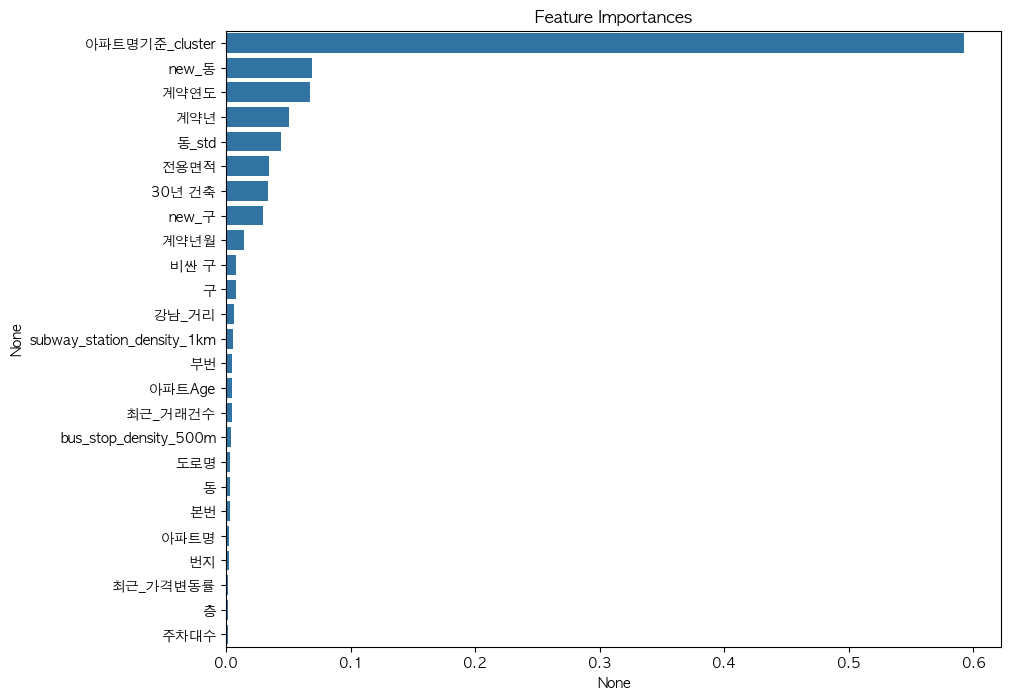

In [40]:
# 위 feature importance
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

rc('font', family='AppleGothic') 			
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10,8))
plt.title("Feature Importances")

sns.barplot(x=importances, y=importances.index)
plt.show()

In [41]:
# Validation dataset에 target과 pred 값 채워줌
X_val['target'] = y_val  # 실제 검증 데이터의 타겟값

# 'target' 컬럼 제거 후 예측 수행
X_val_no_target = X_val.drop(columns=['target'])

# 모델로 예측값 생성
X_val['pred'] = model.predict(X_val_no_target)

# Squared_error를 계산하는 함수를 정의합니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# Squared_error 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors

# RMSE 계산
rmse = np.sqrt(squared_errors.mean())

# RMSE 출력
print(f"xgBoost RMSE: {rmse:.4f}")


xgBoost RMSE: 5736.3622


In [42]:
# 학습된 모델을 저장 / Pickle 라이브러리
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [43]:
dt_test.head(2)

,번지,본번,부번,아파트명,전용면적,계약년월,층,도로명,주차대수,target,...,subway_station_density_1km,new_구,new_동,동_std,아파트명기준_cluster,강남_거리,계약년,최근_거래건수,최근_가격변동률,비싼 구
0,4732,658.0,1.0,328,79.9700,198,5,6176,262.0,0,...,0.0,0,47,27,1.0,0.036380,2023,479.0,0.075377,1
1,4707,651.0,1.0,329,108.2017,200,10,469,305.0,0,...,5.0,0,47,27,2.0,0.031596,2023,403.0,-0.125000,1


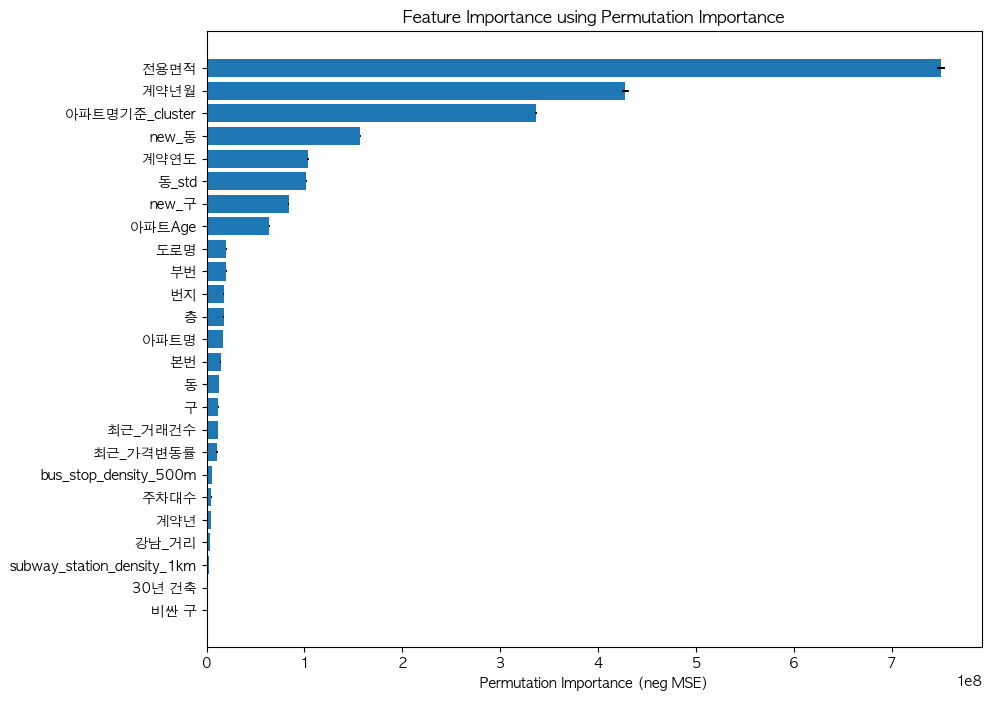

In [45]:
# 검증 데이터에서 예측 결과 관련 열 제거
X_val_clean = X_val.drop(columns=['target', 'pred', 'error'], errors='ignore')

# Permutation importance 계산
result = permutation_importance(
    model,  
    X_val_clean,          # 검증 데이터에서 불필요한 열을 제거한 데이터프레임
    y_val,                # 검증 데이터의 타겟 값
    n_repeats=10,         # 반복 수를 설정하여 더 안정적인 결과를 얻음
    random_state=42,
    scoring='neg_mean_squared_error'  # 회귀 문제에 적합한 평가 지표 사용
)

# 결과를 정렬하여 시각화
sorted_idx = result.importances_mean.argsort()

# 시각화
plt.figure(figsize=(10, 8))
rc('font', family='AppleGothic') 			
plt.rcParams['axes.unicode_minus'] = False
plt.barh(X_val_clean.columns[sorted_idx], result.importances_mean[sorted_idx], xerr=result.importances_std[sorted_idx])
plt.xlabel("Permutation Importance (neg MSE)")
plt.title("Feature Importance using Permutation Importance")
plt.show()

In [46]:
# Error가 큰 순서대로 sorting
X_val_sort = X_val.sort_values(by='error', ascending=False)  

X_val_sort_top100 = X_val_sort.head(100)  
X_val_sort_tail100 = X_val_sort.tail(100) 


In [47]:
# 해석을 위해 레이블 인코딩된 변수를 복원
error_top100 = X_val_sort_top100.copy()
best_top100 = X_val_sort_tail100.copy()

for column in categorical_columns_v2:
    if column in label_encoders:  # 인코더가 있는 경우에만 변환
        error_top100[column] = label_encoders[column].inverse_transform(error_top100[column])
        best_top100[column] = label_encoders[column].inverse_transform(best_top100[column])

In [48]:
display(error_top100.head(5))

,번지,본번,부번,아파트명,전용면적,계약년월,층,도로명,주차대수,구,...,동_std,아파트명기준_cluster,강남_거리,계약년,최근_거래건수,최근_가격변동률,비싼 구,target,pred,error
224567,129,129.0,0.0,PH129,273.960,2022-04-01,16,압구정로79길 88,2112.000000,강남구,...,5,4.0,0.057731,2022,12.0,-0.634043,1,1450000.0,1.031572e+06,1.750824e+11
221950,386,386.0,0.0,르가든더메인한남,227.370,2023-06-01,2,한남대로10길 16,1012.863880,용산구,...,0,3.0,0.057731,2023,23.0,-0.591398,1,465000.0,8.291456e+05,1.326020e+11
241238,129,129.0,0.0,PH129,273.960,2021-03-01,14,압구정로79길 88,1324.235099,강남구,...,5,4.0,0.057731,2021,12.0,-0.634043,1,1150000.0,7.893774e+05,1.300486e+11
138889,467-29,467.0,29.0,타워팰리스3,214.967,2009-05-01,66,언주로30길 26,1973.309927,강남구,...,7,3.0,0.057731,2009,55.0,-0.569231,1,450000.0,1.850685e+05,7.018867e+10
1001952,24,24.0,0.0,용산파크타워,243.850,2009-12-01,37,서빙고로 67,222.884465,용산구,...,12,2.0,0.057731,2009,50.0,-0.372727,1,565000.0,3.541548e+05,4.445572e+10


In [49]:
# 저장된 모델을 불러옴
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [50]:
%%time
X_test = dt_test.drop(['target'], axis=1)

# Test dataset에 대한 inference
real_test_pred = model.predict(X_test)

CPU times: user 330 ms, sys: 22.4 ms, total: 353 ms
Wall time: 55.9 ms


In [51]:
real_test_pred

array([181353.69 , 288443.78 , 310901.1  , ...,  82940.516,  73289.84 ,
        73881.1  ], dtype=float32)

In [52]:
max_value = np.max(real_test_pred)

print("가장 큰 값:", max_value)

가장 큰 값: 1219809.1


In [53]:
# 앞서 예측한 예측값들을 저장
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output1.csv', index=False)